# 1. Settings

## 1.1 User variables

In [1]:
from config import *

NB_RUNS = 30

TARGETS = [TARGET]
HEURISTICS = ["try_all_atoms", "max_coverage_static"] #["max_coverage_static"] #["try_all_atoms", "max_coverage_dynamic", "max_coverage_static", "max_diversity"]
THREADS = 8
USE_NAN = True

DATA_PATH = "tmp/data_discrete.csv"

# 1.2 Dev variables

In [2]:
RANDOM_SEED = 0

INPUT_DATA_DISCRETE = "tmp/data_discrete.csv"
OUTPUT_CSV = "tmp/lfit_output.csv"

VERBOSE = True

## 1.3 Imports

In [3]:
import pandas as pd
import numpy
import random
import pylfit
import os

random.seed(RANDOM_SEED)
numpy.random.seed(RANDOM_SEED)

## 1.4 Constants

In [4]:
# Constants
DEBUG = False

# 2. Data Loading

# DEBUG

In [5]:
# DEBUG
print("Training dataset:")
df = pd.read_csv(DATA_PATH)
cols = [c for c in df.columns if c not in TARGETS]

#df = df.drop(columns=["Poaceae_prev"])

display(df)

for target in TARGETS:
    for val in df[target].unique():
        print(val,len(df[df[target] == val]))

Training dataset:


,M15,Juniperus,Larix,Picea,Pinus,Alnus,Betula,Fraxinus,Populus,Quercus,...,Ambrosia,Artemesia,Asteraceae,Chenopodiaceae,Cyperaceae,Myrica,Poaceae,Typha,Aquatics,Ambrosia_prev
0,-1,-1,1,1,-1,1,-1,1,-1,1,...,-1,1,1,1,-1,1,1,1,0,1
1,1,-1,-1,-1,1,1,1,-1,1,-1,...,1,-1,1,-1,1,-1,-1,-1,0,1
2,-1,1,-1,1,1,-1,-1,1,1,-1,...,1,-1,1,-1,1,-1,-1,1,0,1
3,-1,1,1,-1,-1,1,1,-1,0,1,...,-1,1,0,1,1,1,-1,0,0,0
4,1,0,1,1,-1,-1,-1,1,-1,1,...,-1,-1,-1,-1,-1,-1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,1,-1,-1,-1,1,0,-1,-1,-1,-1,...,-1,-1,1,1,1,1,-1,-1,0,1
57,-1,-1,1,1,-1,1,1,1,1,1,...,1,1,0,-1,1,-1,-1,1,-1,1
58,1,-1,1,1,-1,-1,1,0,1,-1,...,-1,-1,0,-1,-1,1,1,1,1,1
59,-1,1,-1,-1,1,1,1,-1,-1,-1,...,1,1,0,1,-1,1,1,-1,-1,2


-1 27
1 30
0 4


In [6]:
# Load training dataset
cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
df[cols] = df[cols].astype('Int64')
df[cols] = df[cols].astype('string')

if not USE_NAN:
    df = df.dropna()
else:
    df = df.fillna("?")

col_order = list(df.columns)

df_output = pd.DataFrame(columns=["head_variable", "head_value", "body", "rule_size"])

for run_id in range(NB_RUNS):
    # Shuffle variables
    random.shuffle(col_order)
    df = df[col_order]

    FEATURES = [c for c in df.columns if c not in TARGETS]

    df.to_csv("tmp/lfit_input.csv")

    # Convert array data as a DiscreteStateTransitionsDataset using pylfit.preprocessing
    dataset = pylfit.preprocessing.discrete_state_transitions_dataset_from_csv(path="tmp/lfit_input.csv", \
    feature_names=FEATURES, target_names=TARGETS,unknown_values=["?"])

    # Initialize a DMVLP with the dataset variables and set GULA as learning algorithm
    model = pylfit.models.DMVLP(features=dataset.features, targets=dataset.targets)
    model.compile(algorithm="pride") # model.compile(algorithm="pride")
    model.fit(dataset=dataset, options={"heuristics":HEURISTICS, "verbose":0, "threads":THREADS})

    # Save rules
    rules_data = []

    for r in model.rules:
        body = ""
        for i in sorted(list(r.body.items())):
            body += i[1].to_string() + ", "
        if (len(body)>0):
            body = body[:-2]
        rules_data.append([r.head.variable, r.head.value, body, r.size(),r]) #, r.to_string()])

    df_rules = pd.DataFrame(rules_data, columns=["head_variable", "head_value", "body", "rule_size","raw_rule"]) #, "rule_raw_form"])

    nb_rules_of_run = len(df_rules)
    nb_rules_total_before = len(df_output)

    df_output = pd.concat([df_output,df_rules]).reset_index(drop=True)
    df_output.drop_duplicates(subset=["head_variable", "head_value", "body", "rule_size"], inplace=True)

    nb_new_rules = len(df_output) - nb_rules_total_before
    nb_duplicate_rules = nb_rules_of_run - nb_new_rules
    
    print("Run",str(run_id+1)+"/"+str(NB_RUNS),"- new rules found:", nb_new_rules, "- total:",len(df_output),"- duplicate:",nb_duplicate_rules)

    df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output)


Run 1/30 - new rules found: 242 - total: 242 - duplicate: 0
Run 2/30 - new rules found: 145 - total: 387 - duplicate: 61
Run 3/30 - new rules found: 82 - total: 469 - duplicate: 155
Run 4/30 - new rules found: 44 - total: 513 - duplicate: 176
Run 5/30 - new rules found: 87 - total: 600 - duplicate: 113
Run 6/30 - new rules found: 54 - total: 654 - duplicate: 172
Run 7/30 - new rules found: 70 - total: 724 - duplicate: 185
Run 8/30 - new rules found: 30 - total: 754 - duplicate: 211
Run 9/30 - new rules found: 36 - total: 790 - duplicate: 187
Run 10/30 - new rules found: 32 - total: 822 - duplicate: 143
Run 11/30 - new rules found: 41 - total: 863 - duplicate: 203
Run 12/30 - new rules found: 14 - total: 877 - duplicate: 229
Run 13/30 - new rules found: 12 - total: 889 - duplicate: 220
Run 14/30 - new rules found: 12 - total: 901 - duplicate: 213
Run 15/30 - new rules found: 32 - total: 933 - duplicate: 194
Run 16/30 - new rules found: 9 - total: 942 - duplicate: 191
Run 17/30 - new rul

,head_variable,head_value,body,rule_size,raw_rule
0,Ambrosia,-1,"Alnus(1), Cyperaceae(-1), Myrica(1), Quercus(1)",4,"Ambrosia(-1) :- Alnus(1), Cyperaceae(-1), Myri..."
1,Ambrosia,-1,"Alnus(1), Chenopodiaceae(1), Pinus(1), Quercus(1)",4,"Ambrosia(-1) :- Alnus(1), Chenopodiaceae(1), P..."
2,Ambrosia,-1,"Pinus(1), Populus(0), Quercus(1)",3,"Ambrosia(-1) :- Pinus(1), Populus(0), Quercus(1)."
3,Ambrosia,-1,"Ambrosia_prev(1), Myrica(1), Pinus(1), Quercus(1)",4,"Ambrosia(-1) :- Ambrosia_prev(1), Myrica(1), P..."
4,Ambrosia,-1,"Picea(-1), Pinus(1), Quercus(1)",3,"Ambrosia(-1) :- Picea(-1), Pinus(1), Quercus(1)."
...,...,...,...,...,...
1061,Ambrosia,-1,"Alnus(1), Larix(0), Typha(-1)",3,"Ambrosia(-1) :- Alnus(1), Larix(0), Typha(-1)."
1062,Ambrosia,-1,"Alnus(1), Larix(0), Quercus(-1)",3,"Ambrosia(-1) :- Alnus(1), Larix(0), Quercus(-1)."
1158,Ambrosia,0,"Alnus(1), Ambrosia_prev(0), Asteraceae(1), Che...",4,"Ambrosia(0) :- Alnus(1), Ambrosia_prev(0), Ast..."
1168,Ambrosia,1,"Alnus(1), Asteraceae(1), Cyperaceae(1), Populu...",4,"Ambrosia(1) :- Alnus(1), Asteraceae(1), Cypera..."


# Evaluation

In [7]:
def score_rule(rule,df):
    true_pos = 0
    false_pos = 0
    unknown_true_pos = 0
    unknown_false_pos = 0

    for idx, row in df.iterrows():
        matches = "FULL"
        for (var,val) in rule.body.items():
            if (str(row[var]) != "?"):
                if (str(row[var]) != str(val.value)):
                    matches = "NO"
                    break
            else:
                matches = "PARTIAL"

        if matches == "FULL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                true_pos += 1
            else:
                false_pos += 1
        elif matches == "PARTIAL":
            if str(row[rule.head.variable]) == str(rule.head.value):
                unknown_true_pos += 1
            else:
                unknown_false_pos += 1

    if (true_pos + false_pos) == 0:
        accuracy = 0
    else:
        accuracy = true_pos / (true_pos + false_pos)

    if (true_pos + unknown_false_pos) == 0:
        unknown_accuracy = 0
    else:
        unknown_accuracy = true_pos / (true_pos + unknown_false_pos)

    return true_pos, false_pos, accuracy, unknown_true_pos, unknown_false_pos, unknown_accuracy

In [8]:
TRAINING_DATASET = INPUT_DATA_DISCRETE
TEST_DATASET = None

for dataset, state  in [(TRAINING_DATASET, "train"), (TEST_DATASET, "test")]:
    if dataset is None:
        break
    #print("Evaluation of rules on",state,":",dataset)
    true_pos = []
    false_pos = []
    accuracy = []
    unknown_true_pos = []
    unknown_false_pos = []
    unknown_accuracy = []

    df = pd.read_csv(dataset)
    cols = [c for c in df.columns if c not in list(df.select_dtypes(exclude=["number"]).columns)]
    df[cols] = df[cols].astype('Int64')
    df[cols] = df[cols].astype('string')
    if not USE_NAN:
        df = df.dropna()
    else:
        df = df.fillna("?")

    for idx, row in df_output.iterrows():
        tp, fp, acc, utp, ufp, uacc = score_rule(row["raw_rule"], df)
        true_pos += [tp]
        false_pos += [fp]
        accuracy += [acc]
        unknown_true_pos += [utp]
        unknown_false_pos += [ufp]
        unknown_accuracy += [uacc]
        print("\r",str(idx+1)+"/"+str(len(df_output)),end="")

    df_output["support"] = true_pos
    #df_output["false_positives"] = false_pos
    #df_output["accuracy"] = accuracy
    #df_output["unknown_true_positives"] = unknown_true_pos
    #df_output["unknown_false_positives"] = unknown_false_pos
    #df_output["unknown_accuracy"] = unknown_accuracy
    print()


df_output = df_output.sort_values(["support"],ascending=False)
df_output.drop(["raw_rule"], axis=1,inplace=True)

df_output = df_output.drop_duplicates()
df_output.to_csv(OUTPUT_CSV,index=False)

display(df_output[df_output["head_value"] == "1"])

display(df_output[df_output["head_value"] == "-1"])

 1179/1066


,head_variable,head_value,body,rule_size,support
179,Ambrosia,1,"Ambrosia_prev(2), Artemesia(1)",2,9
146,Ambrosia,1,"Ambrosia_prev(2), M15(1)",2,9
241,Ambrosia,1,"Juniperus(1), Populus(-1)",2,7
177,Ambrosia,1,"Ambrosia_prev(1), Betula(1), Cyperaceae(1)",3,7
592,Ambrosia,1,"Artemesia(1), Betula(1), Pinus(-1), Ulmus(1)",4,6
...,...,...,...,...,...
572,Ambrosia,1,"Artemesia(1), Asteraceae(0), Betula(1), Typha(1)",4,1
567,Ambrosia,1,"Alnus(1), Artemesia(1), Pinus(1), Salix(1)",4,1
566,Ambrosia,1,"Artemesia(1), Myrica(0), Salix(1)",3,1
565,Ambrosia,1,"Alnus(1), Cyperaceae(0)",2,1


,head_variable,head_value,body,rule_size,support
248,Ambrosia,-1,"Picea(1), Poaceae(1), Salix(-1)",3,7
70,Ambrosia,-1,"Fraxinus(1), Picea(1), Poaceae(1)",3,7
242,Ambrosia,-1,"Chenopodiaceae(-1), Picea(1), Poaceae(1), Popu...",4,6
387,Ambrosia,-1,"Juniperus(-1), Picea(1), Poaceae(1)",3,6
790,Ambrosia,-1,"Betula(-1), Juniperus(-1), Pinus(1)",3,6
...,...,...,...,...,...
604,Ambrosia,-1,"Fraxinus(-1), Picea(1), Poaceae(1), Populus(1)",4,1
602,Ambrosia,-1,"Chenopodiaceae(1), Picea(1), Pinus(1), Poaceae(1)",4,1
600,Ambrosia,-1,"Alnus(1), Asteraceae(-1), Larix(1), Picea(1)",4,1
546,Ambrosia,-1,"Asteraceae(0), Myrica(1), Quercus(1)",3,1


# Influence Graph extraction

In [9]:
total_rules = len(df_output)
print("Total rules:", total_rules)
df_tmp = df_output[df_output["support"] >= MIN_SUPPORT]
print("With min support", len(df_tmp))

df_up = df_tmp[df_tmp["head_value"] == "1"]
df_down = df_tmp[df_tmp["head_value"] == "-1"]
display(df_up)
display(df_down)

influences = {c:{-1:0,1:0} for c in df.columns}

for (df_tmp, influence_type) in [(df_up, 1),(df_down, -1)]:
    for idx, row in df_tmp.iterrows():
        body = row["body"].split(",")
        body = [i.strip().strip(")").split("(") for i in body]
        #print(influence_type, body, row["support"])

        for var, value in body:
            if value == "1":
                #print(var,"influence",influence_type*int(round(row["support"]/row["rule_size"])))
                influences[var][influence_type] += int(round(row["support"]/row["rule_size"]))
            if value == "-1":
                #print(var,"influence",-influence_type*int(round(row["support"]/row["rule_size"])))
                influences[var][-influence_type] += int(round(row["support"]/row["rule_size"]))

data = []
for var in influences:
    data += [[var, influences[var][-1], influences[var][1]]]

df_influences = pd.DataFrame(data, columns=["Feature","positive_influence","negative_influence"])
df_influences["influence"] = df_influences["positive_influence"] - df_influences["negative_influence"]
df_influences = df_influences.sort_values(by=["influence"],ascending=False)
display(df_influences)

Total rules: 1066
With min support 59


,head_variable,head_value,body,rule_size,support
179,Ambrosia,1,"Ambrosia_prev(2), Artemesia(1)",2,9
146,Ambrosia,1,"Ambrosia_prev(2), M15(1)",2,9
241,Ambrosia,1,"Juniperus(1), Populus(-1)",2,7
177,Ambrosia,1,"Ambrosia_prev(1), Betula(1), Cyperaceae(1)",3,7
592,Ambrosia,1,"Artemesia(1), Betula(1), Pinus(-1), Ulmus(1)",4,6
181,Ambrosia,1,"Betula(1), Juniperus(1), Poaceae(1)",3,6
360,Ambrosia,1,"Aquatics(0), Betula(1), Typha(-1)",3,6
178,Ambrosia,1,"Artemesia(1), Cyperaceae(1), Typha(1)",3,6
316,Ambrosia,1,"Juniperus(1), M15(1), Ulmus(1)",3,6
231,Ambrosia,1,"Juniperus(1), M15(1), Quercus(1)",3,6


,head_variable,head_value,body,rule_size,support
248,Ambrosia,-1,"Picea(1), Poaceae(1), Salix(-1)",3,7
70,Ambrosia,-1,"Fraxinus(1), Picea(1), Poaceae(1)",3,7
242,Ambrosia,-1,"Chenopodiaceae(-1), Picea(1), Poaceae(1), Popu...",4,6
387,Ambrosia,-1,"Juniperus(-1), Picea(1), Poaceae(1)",3,6
790,Ambrosia,-1,"Betula(-1), Juniperus(-1), Pinus(1)",3,6
33,Ambrosia,-1,"Betula(-1), Pinus(1), Poaceae(1), Populus(1)",4,6
793,Ambrosia,-1,"Artemesia(-1), Juniperus(-1), Larix(1)",3,6
62,Ambrosia,-1,"Aquatics(0), Picea(1), Poaceae(1)",3,6
261,Ambrosia,-1,"Aquatics(-1), Chenopodiaceae(-1), Pinus(1)",3,6
662,Ambrosia,-1,"Chenopodiaceae(-1), Juniperus(0), M15(1)",3,6


,Feature,positive_influence,negative_influence,influence
18,Poaceae,34,5,29
3,Picea,19,0,19
8,Populus,15,0,15
4,Pinus,12,3,9
9,Quercus,8,3,5
17,Myrica,4,0,4
2,Larix,6,2,4
7,Fraxinus,4,0,4
19,Typha,9,5,4
20,Aquatics,4,2,2


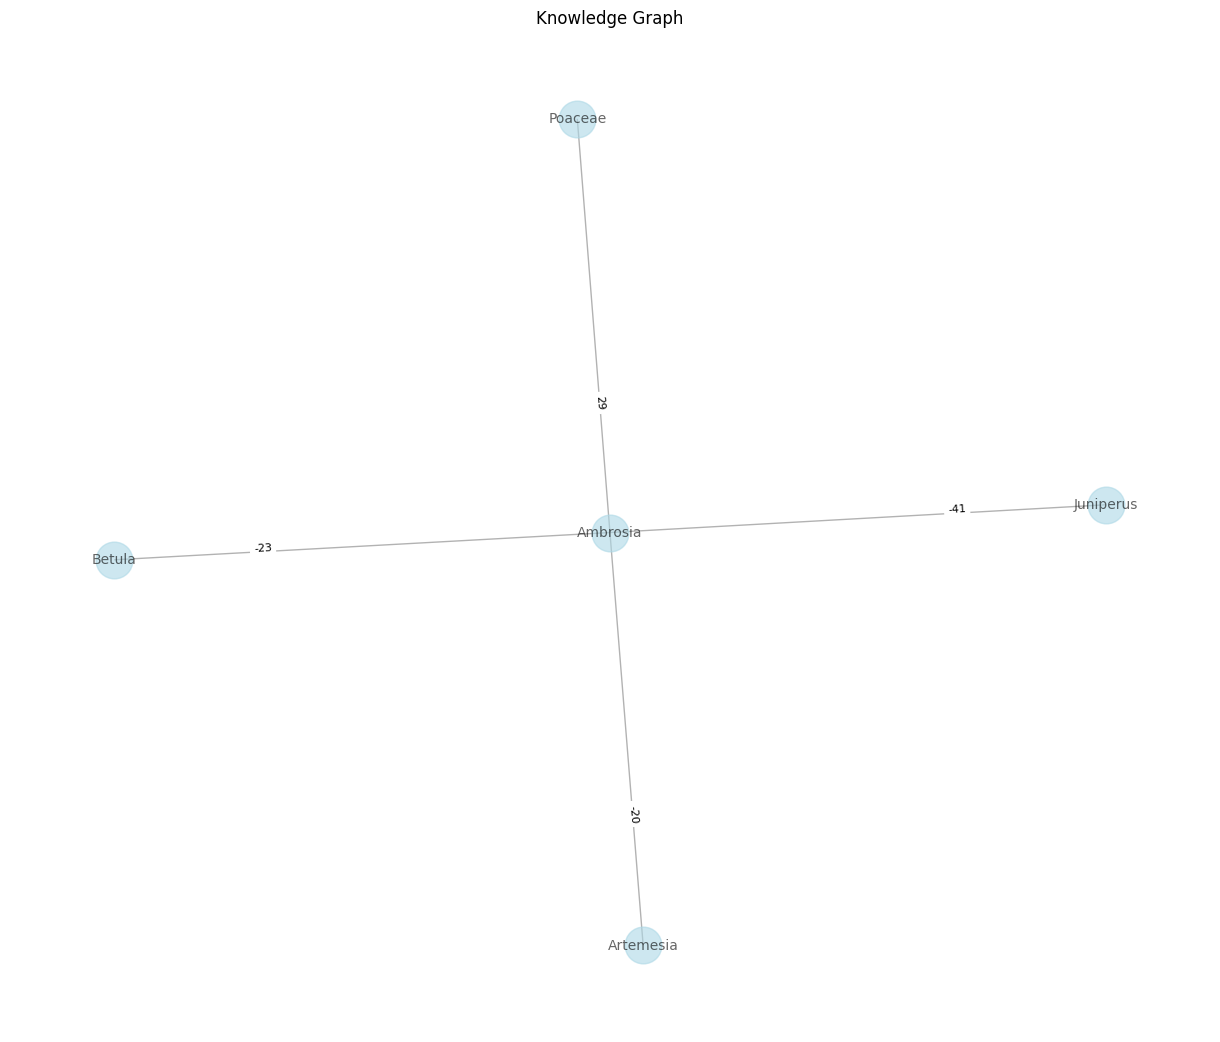

In [10]:
import networkx as nx
import matplotlib.pyplot as plt

MIN_INFLUENCE = 20

# Create a knowledge graph
G = nx.Graph()
for _, row in df_influences.iterrows():
    if abs(row["influence"]) >= MIN_INFLUENCE:
        G.add_edge(row['Feature'], TARGET, label=row['influence'])

# Visualize the knowledge graph
pos = nx.spring_layout(G, seed=42, k=0.9)
labels = nx.get_edge_attributes(G, 'label')
plt.figure(figsize=(12, 10))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=700, node_color='lightblue', edge_color='gray', alpha=0.6)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8, label_pos=0.3, verticalalignment='baseline')
plt.title('Knowledge Graph')
plt.show()

# TODO